In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from datetime import date
import matplotlib.gridspec as grd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
#Addign a progress bar to iterations
from tqdm import tqdm

#gamma function and integration
from scipy import special, optimize, linalg
from scipy import integrate
from scipy import stats


#Fitting the spectrum
from scipy.optimize import curve_fit

#Bayesian fit
import ultranest
from ultranest.plot import cornerplot
import ultranest.stepsampler


#Using csv tables
import pandas as pd

#Astropy module to handle units
import astropy
from astropy.io import ascii
from astropy import units as u
from astropy.units import Quantity
from astropy import constants as const

#Importing the constant that will be needed
from astropy.constants import c, k_B, m_e, e

#Colors and ratios for graphs
import seaborn as sns
golden = (1 + 5 ** 0.5) / 2
sns.set_palette("muted")
colors = sns.color_palette("muted")
colors_dark = sns.color_palette("bright")
colors_dark.append('turquoise')
colors_dark.append('navy')

# Loading the previus results

In [2]:
resultB=np.load('Results/resultB.npy', allow_pickle=True).item() #Item to access to the dictionary data
result=np.load('Results/result.npy', allow_pickle=True).item()
perrB=np.load('Results/perrB.npy', allow_pickle=True)
perr=np.load('Results/perr.npy', allow_pickle=True)
data_rec=np.load('Results/data_rec.npy', allow_pickle=True)
days=np.load('Results/days.npy', allow_pickle=True)

date_list=[]
for i in np.arange(0,len(days)):
    date_list.append([[], [], []])

roundDecim=0
for freq in data_rec:
    day= round(freq['Days since detection'],roundDecim)
    Frequency=freq['Frequency (GHz)']
    Flux=freq['Flux density (mJy)']
    FluxErr=freq['Flux density error (mJy)']
    for i, DayData in enumerate(days):
        if day == round(DayData,roundDecim):
            #Saving the data from this day top an array
            date_list[i][0].append(Frequency)
            date_list[i][1].append(Flux)
            date_list[i][2].append(FluxErr)

# 1. Charactericing the host using 150MHz data.

In [3]:
#Previus result prediction for 150MHz
result['x'][0]*(0.15/1.28)**(result['x'][1])

1.2739143284112386

In [4]:
#Promediating weightened by uncertainties all the points we have to have a measure at 0.15
dataHost= np.array([1.119, 1.138, 1.521, 1.277])
errHost= np.array([0.114, 0.170, 0.137, 0.147])

weightsHost= 1/errHost

meanHost= np.dot(dataHost,weightsHost)/(weightsHost).sum()
errMeanHost= 1/np.sqrt((weightsHost).sum())

In [5]:
def FluxHostGalax(frequency, alpha):
    """
    Returns the flux for the hsot galaxy at the given frequencie

    Prameters
    :frequency: Frequency in GHz
    :alpha: power law index

    Output
    :FluxHost: Flux at the given frequency in mJy
    :FluxHostErr: uncertainty of the host galaxy flux
    
    """
    FluxHost= meanHost*(frequency/0.15)**(alpha)
    FluxHostErr= np.abs((frequency/0.15)**(alpha))*errMeanHost
    return (FluxHost, FluxHostErr)

# 2. Synchrotron functions

In [6]:
#Defininf Pacholcyzk's constants
c1=(const.e.esu*3/(4*np.pi*const.m_e.cgs**3*const.c.cgs**5)).cgs.value

c3=(const.e.esu**3*np.sqrt(3)/(4*np.pi*const.m_e.cgs*const.c.cgs**2)).cgs.value

def Pacholcyzk5(p):
    """
    Pacholcyzk5 returns the value of the Pacholcyzk c5 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c5: Value of the constant
    """
    c5=3**0.5/(16*np.pi)*(const.e.esu**3/(const.m_e*const.c**2))*(p+7/3)/(p+1)*scipy.special.gamma((3*p-1)/12)*scipy.special.gamma((3*p+7)/12)
    #return only the value in cgs units to make possible a fit
    return c5.cgs.value
    
def Pacholcyzk6(p):
    """
    Pacholcyzk6 returns the value of the Pacholcyzk c6 constant given p
    Parameters
    :p: Coefficient of the power law defining the electron population

    Output
    :c6: Value of the constant
    """
    c6=np.pi*3**0.5/(72)*const.e.esu*const.m_e**5*const.c**10*(p+10/3)*scipy.special.gamma((3*p+2)/12)*scipy.special.gamma((3*p+10)/12)
    return c6.cgs.value

In arXiv:1301.6759 we can see that the energy is minimized when (330-340 en sjoert son clave para esto y el cut off)
$$
    E_B=\frac{6}{11}E_e,
$$
with
$$
        \frac{E_e}{V}=\frac{N_e}{V} m_e c^2 \gamma_e= N_0 \int  E E^{-p}dE ~~~~~~ \frac{E_B}{V}= \frac{B^2}{8\pi}.
$$
So we can define a function that computes the electron density from the magnetic field.
$$
            N_0=\frac{11}{6} \left( \frac{8\pi}{B^2}  E\int E^{-p}dE \right)^{-1} = \frac{6}{11} \frac{(2-p) B^2}{8\pi}  \left( \frac{1}{E_{max}^{2-p} -E_{min}^{2-p}} \right)
$$

In [7]:
def N0fromB(B, fV, R, p, Emax=1e6*(const.m_e.cgs*const.c.cgs**2).value, Emin=(const.m_e.cgs*const.c.cgs**2).value):
    """
    Gives the electron number density for a synchtron source assuming equipartition energy 
    from the radius and magnetic field
    
    Parameters
    :B: Magnetic field of the source
    :fV: Volume filling factor for the geometry 4/3 for a cone
    :R: Radius of the source
    :Emax: Maximun energy of the relativistic electrons
    :Emin: Minimun energy of the relativistic electrons

    Output
    :N0: Electron number density at the given magnetic field and radius
    """

    N0= 11/6*(2-p)*B**2/(8*np.pi)*1/(Emax**(2-p)-Emin**(2-p))

    return N0

In [8]:
def SynchrotronEmissionCoeff(p, B, N0, frequency):
    """
    Returns the emission coefficient for a synchrotron emisison of a population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the emission coefficient want to be calculated

    Output
    :EmissionCoeff: Emission coefficient value
    """

    EmissionCoeff=Pacholcyzk5(p)*N0*B**((p+1)/2)*(frequency/(2*c1))**((1-p)/2)
    return EmissionCoeff

def SynchrotronAbsorptionCoeff(p, B, N0, frequency):
    """
    Returns the absorption coefficient for a synchrotron population of relativistic electrons

    Parameters
    :p: Coefficient of the power law defining the electron population
    :B: Magnetic field
    :N0: Constant of the power law
    :frequency: frequency at which the absorption coefficient want to be calculated

    Output
    :AbsorptionCoeff: absorption coefficient value
    """

    AbsorptionCoeff=Pacholcyzk6(p)*N0*B**((p+2)/2)*(frequency/(2*c1))**(-(p+4)/2)
    return AbsorptionCoeff

def SourceFuncSynch(p, B, N0, frequency):
    """
    returns the value of the source function for a given frequency

    Parameters
    :p: Exponent of the power law of electron population
    :B: Value of the magnetic field
    :N0: Constant of the power law
    :Ne: Thermal electron number density
    :Te: Temperature of the electrons
    :frequency: frequency at which the source function want to be calculated
    
    Output
    :S: Value of the source function at the given frequency
    """

    S=SynchrotronEmissionCoeff(p, B, N0, frequency)/(SynchrotronAbsorptionCoeff(p, B, N0, frequency))
    return S


def SpecIntSynch(p, B, N, radius, frequency):
    """
    SpecIntSynch returns the specific intensity of a population of relativistic electrons driven by a power law at a given
    frequency

    Paramenters
    :p: exponent of the power law
    :B: Magnetic field
    :N: Constant of the power law
    :radius: Radius of the emiting region
    :frequency: frequency at which the specific intensity is computed

    Output
    :I: specific intensity at the given frequency
    """

    S = SourceFuncSynch(p, B, N, frequency)
    kappa= SynchrotronAbsorptionCoeff(p, B, N, frequency)
    
    I=S*(1 - np.exp(-radius*kappa))
    return I

def solidangle(radius, distance):
    """
    solidangle gives the solid angle of a source at distance d and size r in the small angle approximation.If units are 
    desired at the output, they must be inserted in the parameters with unit module

    Parameters
    :radius: radius of the source
    :distance: distance from Earth to source

    Outputs
    :omega: solid angle of the source
    """
    #Applying the expresion for the solid angle in the small angle approximation
    omega= np.pi * (radius**2)/(distance**2)
    return omega

def FluxatTSynch(frequency, r, p, B, distance, alpha):
    """
    Flux returns the value of the flux foor a population of relativistic electrons driven by a power law at a given frequency

    Parameters
    :frequency: frequency at which the specific intensity is computed in Hz
    :p: exponent of the power law describing electron population
    :B: Magnetic field at the epoch
    :N: Constant of the power law at the epoch
    :distance: Distance to the source
    :F0: Steady radio emission from the host galaxy+
    :alpha: Base flux of the hsot galaxy power law exponent
    
    Output
    :F: Flux of the source
    """
    B= 10**B
    r=10**r
    Fbase= FluxHostGalax(frequency*1e-9, alpha)[0]
    N=N0fromB(B, 1.15, r, p)
    
    F=Fbase + solidangle(r, distance)*SpecIntSynch(p, B, N, r, frequency)*1e23*1e3 # to convert to cgs units #In order to get from cgs to Jy
    return F 


In [9]:
def freqtowavelenght(frequency):
    """
    Transforms from frequency to wavelenght

    Parameters
    :frequency: Input frequency

    Output
    :wavelenght:
    """
    frequency=frequency.to(u.Hz)
    return (const.c/frequency).decompose()

def wavelenghttofreq(wavelenght):
    """
    Transforms from wavelenght to frequency

    Parameters
    :wavelenght: Input wavelenght

    Output
    :frequency:
    """
    wavelenght=wavelenght.to(u.m)
    return (const.c/wavelenght).decompose()

# 3. Least squares fit

In [10]:
#Defining function with B proportional to R
def BPowerLaw(radius, radius0, B0, alpha):
    return B0*(radius/radius0)**alpha

def my_likelihood(params, args):
    #Time independent parameters
    alpha= params[0]
    alphaB=params[1]
    R0= params[2]


    #Arguments
    frequency = args[0]
    num_times= args[1]
    distance = args[2]
    FluxValue= args[3]
    FLuxErr= args[4]
    B0=args[5]

    #Time dependent parameters
    R= np.ones(num_times)
    p= np.ones(num_times)
    
    R=params[2:num_times+3]
    p = params[num_times+3:]
    B = B0 + alphaB*(R - R0)

    like=0
    #Fit each time
    for i in np.arange(0, num_times):
        for j in np.arange(0, len(frequency[i])):
            FluxFit= FluxatTSynch(frequency[i][j]*1e9 , R[i], p[i], B[i], distance, alpha)
            like= like -0.5*( ((FluxValue[i][j] - FluxFit)/FLuxErr[i][j])**2 )
    return like


def my_prior_transform(cube, prior):
    params = cube.copy()

    #We put here the prior parameters obtained by the least_sq fit and its uncertainties
    for i in np.arange(0, prior.size):
        width= np.abs(0.01*prior[i])/4
        lower_bound= prior[i] - width/2
        params[i] = cube[i]*width + lower_bound

    return params

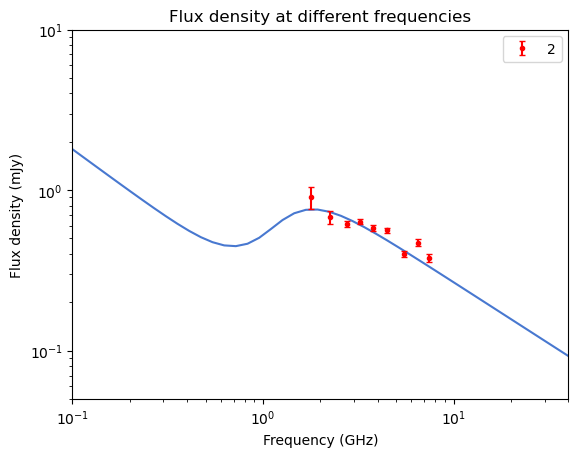

In [11]:
#Input parameters
freqcont= np.logspace(-1, 2, base=10) #In mHz
distance= ((96*u.Mpc).to(u.cm)).value 

alpha= -0.87

num_times=len(days)
B=np.ones(num_times)
N=np.ones(num_times)
R=np.ones(num_times)
#Ussually p is fixed but GoodWing argue that for this TDE it is observed that it is not
p=np.ones(num_times)

B[5]= (0.05*u.G).value
R[5]= (1.3e17*u.cm).value
p[5]=2.6

B[4]= (0.07*u.G).value
R[4]= (9e16*u.cm).value
p[4]=2.5

B[3]= (0.08*u.G).value
R[3]= (0.9e17*u.cm).value
p[3]=2.6

B[2]= (0.08*u.G).value
R[2]= (6e16*u.cm).value
p[2]=2.5

B[1]= (0.35*u.G).value
R[1]= (3.5e16*u.cm).value
p[1]=2.2

B[0]= (0.4*u.G).value
R[0]= (3.5e16*u.cm).value
p[0]=2.1

B[6]= (0.05*u.G).value
R[6]= (1.3e17*u.cm).value
p[6]=2.5

B[7]= (0.05*u.G).value
R[7]= (1.1e17*u.cm).value
p[7]=2.3

B[8]= (0.1*u.G).value
R[8]= (8e17*u.cm).value
p[8]=3

B[9]= (0.06*u.G).value
R[9]= (2.7e17*u.cm).value
p[9]=2.6

B[10]= (0.06*u.G).value
R[10]= (8e17*u.cm).value
p[10]=3

B[11]= (0.1*u.G).value
R[11]= (2e17*u.cm).value
p[11]=2.7

#Since this amgnitudes have quite different values (orders of magnitude) we give them to the functions as teh log
alphaB=-0.45
R0=np.log10(0.4e16)
B= np.log10(BPowerLaw(R, 10**R0, 10**resultB.x[1], alphaB))
R= np.log10(R)

i=2
F= FluxatTSynch(freqcont*1e9 , R[i], p[i], B[i], distance, alpha)
plt.plot(freqcont, F)
plt.errorbar(date_list[i][0], date_list[i][1], yerr=  date_list[i][2],fmt= '.',capsize= 2 , c='red',
             zorder=8, label= f'{i}')
     

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.xlim(left=0.1, right= 40) 
plt.ylim(bottom=0.5e-1, top=10)
plt.show()

In [12]:
#Input parameters
freqcont= np.logspace(-1, 2, base=10) #In mHz
distance= ((96*u.Mpc).to(u.cm)).value 
num_times=7#len(days)
start=0

freq = []
FluxValue = []
FluxErr = []

#Saving the data at each epoch in arrays
for time in date_list:
    freq.append(time[0])
    FluxValue.append(time[1])
    FluxErr.append(time[2])

params0=list([alpha, alphaB, R0])
for i in np.arange(start, start+num_times):
    params0.append(R[i])
for i in np.arange(start, start+num_times):
    params0.append(p[i])

params0= np.array(params0)
args0=(freq, num_times, distance, FluxValue, FluxErr, resultB.x[1])

param_names=list(('alpha', 'alphaB', 'R0'))
for i in np.arange(start, start+num_times):
    param_names.append(f'R[{i}]')
for i in np.arange(start, start+num_times):
    param_names.append(f'p[{i}]')

slice_steps=4*len(param_names)+3
#resultBPL = scipy.optimize.least_squares(leastsq_function, x0 = params0, args=args0, verbose=2)
sampler = ultranest.ReactiveNestedSampler(param_names, lambda params: my_likelihood(params, args0), lambda cube: my_prior_transform(cube, params0))
sampler.stepsampler = ultranest.stepsampler.SliceSampler(nsteps=slice_steps,
        generate_direction=ultranest.stepsampler.generate_mixture_random_direction,)

In [ ]:
BayesianResult = sampler.run()
sampler.print_results()

[ultranest] Sampling 400 live points from prior ...


In [ ]:
cornerplot(BayesianResult)

In [ ]:
BayesianResult

In [ ]:

ResultArray=BayesianResult['posterior']['mean']
F= FluxatTSynch(freqcont*1e9 , ResultArray[3], ResultArray[4], np.log10(BPowerLaw(10**ResultArray[3], 10**ResultArray[2], 10**resultB.x[1],
                                                                        resultBPL.x[1])), distance, resultBPL.x[0])
plt.plot(freqcont, F)
plt.errorbar(date_list[start][0], date_list[start][1], yerr=  date_list[start][2],fmt= '.',capsize= 2 , c='red',
             zorder=8, label= f'{start}')
     

plt.yscale('log')
plt.xscale('log')
plt.xlabel(f"Frequency (GHz)")
plt.ylabel(f'Flux density (mJy)')
plt.title('Flux density at different frequencies')
plt.legend()
plt.xlim(left=0.1, right= 40) 
plt.ylim(bottom=0.5e-1, top=10)
plt.show()

In [ ]:
sizefig=10
plt.figure(figsize=(sizefig*golden, sizefig))
fig, ax = plt.subplots(4,3)

for freq in data_rec:
    day= round(freq['Days since detection'],roundDecim)
    Frequency=freq['Frequency (GHz)']
    Flux=freq['Flux density (mJy)']
    FluxScaled=Flux -ResultArray[0]*(Frequency/1.28)**(ResultArray[1])
    FluxErr=freq['Flux density error (mJy)']
    for i, DayData in enumerate(days):
        if day == round(DayData,roundDecim):
            Index1= i%3
            Index2=0
            if i >=3: Index2= int((i-Index1)/3)
            ax[Index2][Index1].errorbar(Frequency, FluxScaled, yerr= FluxErr, 
                         fmt= '.',capsize= 2 , c=colors_dark[i], zorder=8, label= f'Day {day}')
            date_list[i][0].append(Frequency)
            date_list[i][1].append(Flux)
            date_list[i][2].append(FluxErr)
            
            ax[Index2][Index1].set_yscale('log')
            ax[Index2][Index1].set_xscale('log')
            ax[Index2][Index1].set_ylim(bottom=0.1, top=10)
            ax[Index2][Index1].set_xlim(left=0.1, right=20)
            ax[Index2][Index1].set_xlabel(f"Frequency (GHz)")
            ax[Index2][Index1].set_ylabel(f'Flux density (mJy)')

            if Index1 != 0:  
                plt.setp(ax[Index2][Index1].get_yticklabels(), visible= False)
            if Index2 != ax.shape[1]:  
                plt.setp(ax[Index2][Index1].get_xticklabels(), visible= False)

ResultArray=BayesianResult['posterior']['mean']
for i, DayData in enumerate(days):
    Index1= i%3
    Index2=0
    if i >=3: Index2= int((i-Index1)/3)
    BValue= np.log10(BPowerLaw(10**ResultArray[3  + i], 10**ResultArray[2], 10**resultB.x[1],resultBPL.x[1]))
    F= FluxatTSynch(freqcont*1e9 , ResultArray[3 + i], resultBPL['x'][3 + num_times + i], BValue
                    , distance, resultBPL['x'][0])
    ax[Index2][Index1].plot(freqcont, F, c=colors_dark[i])

#Function to only plot labels once
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

for i, DayData in enumerate(days):
    Index1= i%3
    Index2=0
    if i >=3: Index2= int((i-Index1)/3)
    legend_without_duplicate_labels(ax[Index2][Index1])

fig.set_figheight(sizefig)
fig.set_figwidth(sizefig*1.1)

plt.tight_layout()
plt.show()